In [1]:
$ !mkdir -p ~/aiffel/chest_xray
$ !ln -s ~/data/ ~/aiffel/chest_xray

ln: failed to create symbolic link '/aiffel/aiffel/chest_xray/data': File exists


In [5]:
# 패키지(라이브러리)들을 import 
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

##  STEP1. 실험환경 set-up

In [6]:
# 필요한 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS =25

print(ROOT_PATH)

/aiffel/aiffel


## STEP2. 데이터 준비하기

In [7]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


# STEP5.  데이터 imbalance 처리

In [8]:
# val 데이터가 너무 적어서 train 데이터랑 합한 후 다시 8:2로 나누기
# train 데이터와 validation 데이터를 모두 filenames에 담는다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [9]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [10]:
# 정상, 페렴 이미지 개수 파악
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [11]:
# tf.data 인스턴스 만들기. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해준다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [12]:
# train, val 데이터 수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [13]:
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터 만들어 주는 함수 만들기
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [14]:
# 이미지를 알맞은 형식으로 바꾸기
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어오기
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [15]:
# train 데이터 셋과 validation 데이터 셋 만들기. 
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수 이용하면 더욱 빠르게 데이터 처리 가능

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
# 이미지가 제대로 리사이즈 되었는지, 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):   #  train_ds.take(1)은 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [17]:
# 테스트 데이타 셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


# STEP3. 데이터 시각화
### LMS상의 자료와 좌우 반전한 사진 비교하기 위해 두 가지 코드 모두 실행 - 뚜렷한 차이를 보긴 어렵다. 전문가가 아니라서 그런가? 일반적으로 오른쪽 폐가 왼쪽 폐보다 크다고 하는데 그걸 염두해보면 좌우가 바뀐 모양인것 같기는 하다..
### 순차적으로 같이 실행하니 좌우 반전된 코드에서 오류가 발생..

In [14]:
# LMS 상의 내용, 아래의 좌우 반전과 비교하기 위해 실행
def prepare_for_training(ds, shuffle_buffer_size=1000): # 데이터 변환시켜주기
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds2 = prepare_for_training(train_ds)
val_ds2 = prepare_for_training(val_ds)

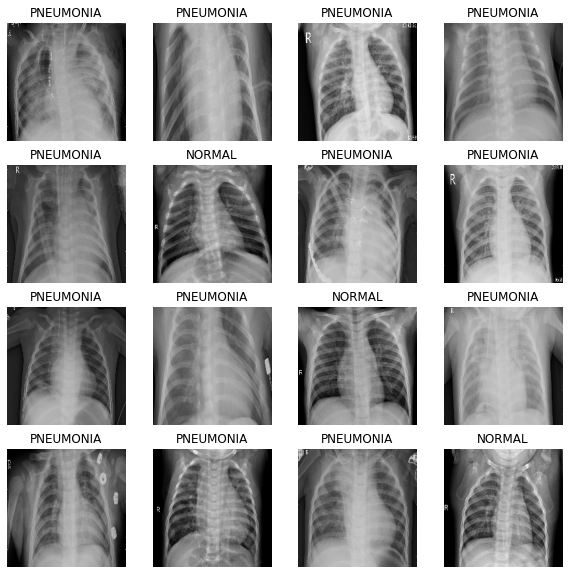

In [15]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())


In [18]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds1 = prepare_for_training(train_ds)
val_ds1 = prepare_for_training(val_ds)

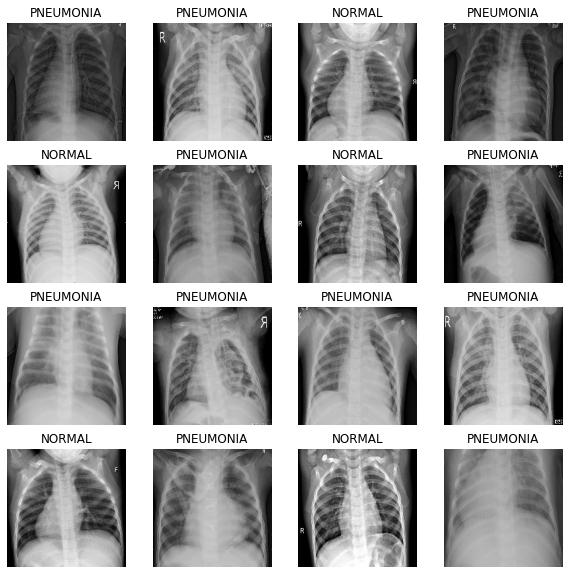

In [19]:
# 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출. 
# 추출된 배치를 image와 label 데이터 셋으로 나누기. 이제 show_batch() 함수를 이용해서 결과 사진
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# STEP4.  CNN 모델링
### Convolution block을 만들기 =>  conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결 => Max Pooling을 한다.

In [20]:

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 128, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 128, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

## dense block 만들기, 전형적인 CNN 모델과는 약간 다른 모델로 수정, Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용

In [21]:
# Batch Normalization, Dropout 모두 사용한 경우
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [22]:
# Batch Normalization, Dropout 모두 사용한 경우
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [23]:
# 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',   # 이미지의 라벨이 두 개
        metrics=METRICS
    )

In [24]:
# weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅 =>
# 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [25]:
# 모델 fit 하기, 20분 정도 소요
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 1111s 4s/step - loss: 0.8259 - accuracy: 0.5192 - precision: 0.7695 - recall: 0.5050 - val_loss: 3.5955 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 1100s 4s/step - loss: 0.7499 - accuracy: 0.5378 - precision: 0.7964 - recall: 0.5087 - val_loss: 0.6384 - val_accuracy: 0.5779 - val_precision: 0.7239 - val_recall: 0.6889
Epoch 3/25
261/261 [==============================] - 1101s 4s/step - loss: 0.7101 - accuracy: 0.5450 - precision: 0.8041 - recall: 0.5146 - val_loss: 0.6841 - val_accuracy: 0.6952 - val_precision: 0.7258 - val_recall: 0.9412
Epoch 4/25
261/261 [==============================] - 1105s 4s/step - loss: 0.6385 - accuracy: 0.5886 - precision: 0.8544 - recall: 0.5376 - val_loss: 1.2536 - val_accuracy: 0.7346 - val_precision: 0.7375 - val_recall: 0.9948
Epoch 5/25
261/261 [==============================] - 1104s 4s/step - loss: 0.5732 - accuracy: 0

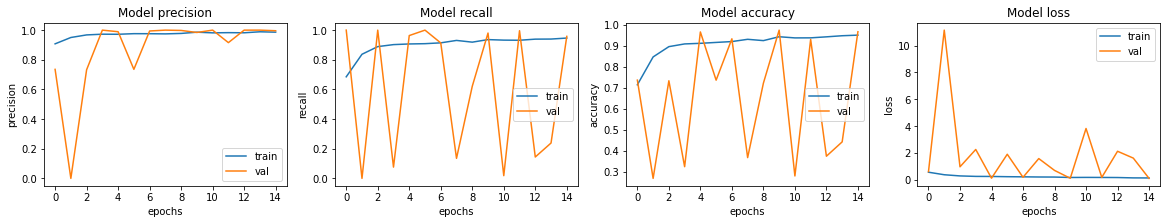

In [64]:
# 결과확인(lms 조건)
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [63]:
# 모델 fit 하기, 20분 정도 소요
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds2,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
261/261 [==============================] - 1137s 4s/step - loss: 0.5502 - accuracy: 0.7136 - precision: 0.9075 - recall: 0.6851 - val_loss: 0.5972 - val_accuracy: 0.7356 - val_precision: 0.7353 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 1129s 4s/step - loss: 0.3612 - accuracy: 0.8463 - precision: 0.9503 - recall: 0.8372 - val_loss: 11.1653 - val_accuracy: 0.2673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
261/261 [==============================] - 1130s 4s/step - loss: 0.2733 - accuracy: 0.8954 - precision: 0.9677 - recall: 0.8889 - val_loss: 0.9547 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 1129s 4s/step - loss: 0.2380 - accuracy: 0.9083 - precision: 0.9726 - recall: 0.9023 - val_loss: 2.2492 - val_accuracy: 0.3231 - val_precision: 1.0000 - val_recall: 0.0761
Epoch 5/15
261/261 [==============================] - 1130s 4s/step - loss: 0.2328 - ac

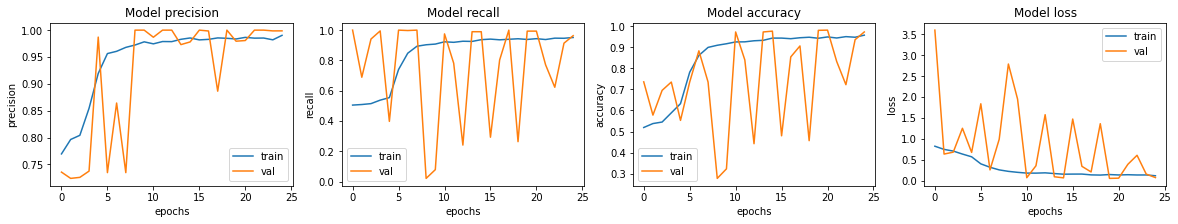

In [26]:
# 결과확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
# 테스트 데이타로 성능 확인(lms와 동일하게 수행) - 정확도가 0.821 정도로 나옴
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 24s 611ms/step - loss: 0.5186 - accuracy: 0.8205 - precision: 0.7932 - recall: 0.9641
Loss: 0.5186071991920471,
Accuracy: 0.8205128312110901,
Precision: 0.7932489514350891,
Recall: 0.964102566242218


# 결과 확인 및 시각화 : batch size : 16, epochs : 15, Conv2D(filters : 128인 경우
## 정확도가 0.814 정도 나옴(아래 그래프)

In [65]:
# 테스트 데이타로 성능 확인(lms와 동일하게 수행)
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 25s 623ms/step - loss: 0.4808 - accuracy: 0.8141 - precision: 0.7751 - recall: 0.9897
Loss: 0.48081979155540466,
Accuracy: 0.8141025900840759,
Precision: 0.7751004099845886,
Recall: 0.9897435903549194


# LMS 상황 : batch size : 16, epochs : 25, Conv2D(filters, 16) 정확도 : 0.841

batch size : 16, epochs : 25, tf.keras.layers.SeparableConv2D(filters, 16, activation='relu', padding='same')로 변경하기 전 결과(LMS)
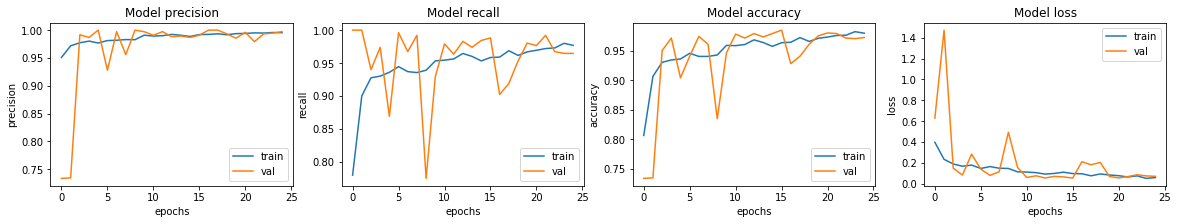


39/39 [==============================] - 5s 117ms/step - loss: 0.8598 - accuracy: 0.8413 - precision: 0.8025 - recall: 0.9897
Loss: 0.8598130345344543,
Accuracy: 0.8413461446762085,
Precision: 0.8024948239326477,
Recall: 0.9897435903549194

 # batch size : 15, epochs : 5, Conv2D(filters, 32) 정확도 : 깜빡 저장 못함
 ### train data의 손실은 위의 그래프들과 패턴이 비슷하나, validation data의 경우 위의 그래프와 패턴이 다름을 알 수 있다. 정확한 것은 숫자로 표현을 하는데..

batch size : 15, epochs : 5, tf.keras.layers.SeparableConv2D(filters, 32, activation='relu', padding='same')로 변경했을 때 결과

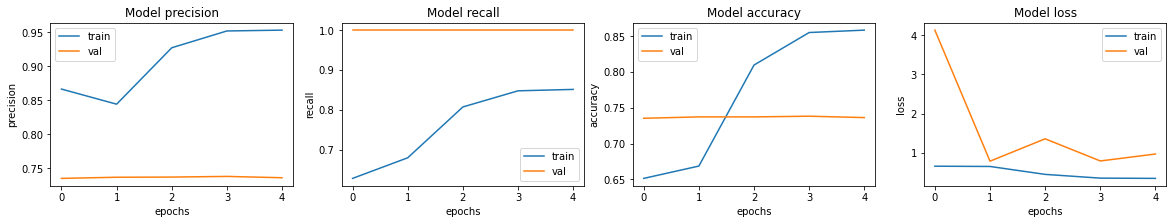

# batch size : 32, epochs : 10, Conv2D(filters, 64) 정확도 : 0.663
### batch 사이즈를 기준보다2배로 높이고 epochs는 낮추고, filters는 64로 4배 올렸는데도 정확도는 많이 낮은편이다. batch size가 크고 epochs가 작아 정밀히 훈련을 하지 못한 것이 이유인 것 같다.

batch size : 32, epochs : 10, tf.keras.layers.SeparableConv2D(filters, 64, activation='relu', padding='same')로 변경했을 때 결과

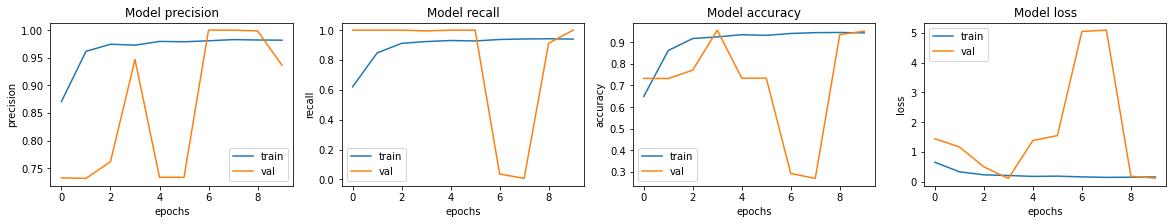

테스트 데이타로 성능 확인
20/20 [==============================] - 8s 405ms/step - loss: 0.8712 - accuracy: 0.6635 - precision: 0.6500 - recall: 1.0000 Loss: 0.8712031245231628, Accuracy: 0.6634615659713745, Precision: 0.6499999761581421, Recall: 1.0

# batch size : 16, epochs : 15, Conv2D(filters, 128) 정확도 : 0.814

batch size : 16, epochs : 15, tf.keras.layers.SeparableConv2D(filters, 128, activation='relu', padding='same')로 변경했을 때 결과
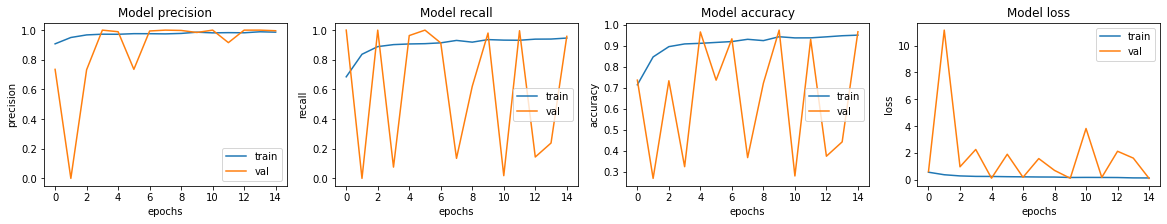

Loss: 0.48081979155540466,
Accuracy: 0.8141025900840759,
Precision: 0.7751004099845886,
Recall: 0.9897435903549194


## Batch Normalization만 사용한 경우 - 위의 과정 실행하는데 시간이 너무 오래 소요되어 진행하지 못함
##  Dropout 만 사용한 경우 - 위의 과정 실행하는데 시간이 너무 오래 소요되어 진행하지 못함

# 회고
### 1. 1회 수행하는데 맨 처음 LMS에서 진행할 때는 20-30분 정도 소요되었으나 그 이후로 batch size, epochs, filter를 변경하면서 수행시 거의 3-4 시간씩 소요가 되어 더 이상 수행하기에 어려움이 있었다. 
### 다른분들은 early stopping을 이용하여 시간은 짧으면서도 효과적으로 결과를 얻었다고 하는데.. 생각은 해 봤으나 코드를 제대로 작성을 하지 못해, 그리고 현재 수행하는 것이 멈추질 못해 시도하질 못하였다. 

### 2.  2018년 소아의 골연령을 판독해 키를 예측하는 VUNO Med®-BoneAge™를 개발해 국내 1호 인공지능 의료기기 인허가를 획득했다. 최근에는 흉부 X-ray에 AI를 접목시킨 인공지능 기반 흉부 X-ray 판독 보조 솔루션 뷰노메드 체스트 엑스레이™를 개발했다는 기사를 보았다. 이처럼 실전에서 정확한 결과를 알아내는 인공지능 분야가 늘어나리라 기대한다. 그러기 위해선 많은 데이터의 확보가 가장 중요하리라 생각된다. 이번 노드에서 진행한 것은 데이터의 수가 적어(데이터의 수 이외의 조건도 영향을 주었겠지만) 정확도가 84%로 의사가 직접 보는 것 보다 신뢰성이 떨어지면 사람의 생명과도 직결되기 때문에 좋은 성능의 인공지능을 개발해야 한다. 